# Desafio Forecast - Parte 1

## Autor: Raphael Paes Pinto

In [1]:
# Pacotes necessários

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#!pip install pymannkendall
import pymannkendall as mk

# configurando pros gráficos ficarem ajustados
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

### Dados

In [2]:
# Bases de dados - ocorrências de acidentes de trânsito na cidade de Recife (fonte: https://www.emprel.gov.br/)
# dados de 2015 a 2019 (os dados de 2015 está organizado diferente dos demais, visto previamente no notepad++)
# criei duas pastas para separar os dados, organizando para fazer a leitura

# dados de 2015
df_2015 = pd.read_csv(r'C:\Users\rapha\Documents\desafio_forecast\dataset\2015\acidentes-transito-2015.csv', sep = ',', decimal = '.')

# de 2016 a 2019 - usando uma função pronta que eu já tenho e faz uma leitura e une todas as bases a partir do seu formato
path = r'C:\Users\rapha\Documents\desafio_forecast\dataset\2016-2019' # pasta
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep = ',')
    li.append(df)
df_demais_anos = pd.concat(li, axis=0, ignore_index=True)

In [3]:
# Trabalhando as bases separadamente, num primeiro momento

##### 2015

In [4]:
df_2015.head()

,natureza_acidente,situacao,data,hora,bairro,endereco,numero,complemento,natureza,descricao,...,pedestre,onibus,caminhao,viatura,outros,vitimas,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,SEM VÍTIMA,CANCELADA,2015-12-03,11:36:00.000,CASA AMARELA,AV NORTE,NaN,SENTIDO SUBURBIO E/F AO SESC,COLISÃO,COLISÃO SEM VITIMAS,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,SEM VÍTIMA,FINALIZADA,2015-06-01,06:35:00.000,ENCRUZILHADA,EST DE BELEM,NaN,IGREJA BATISTA MEMORIAL DE BELÉM,COLISÃO,SEM VÍTIMAS.,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,SEM VÍTIMA,FINALIZADA,2015-06-01,08:04:00.000,BOA VIAGEM,RUA ERNESTO DE PAULA SANTOS,NaN,SEMAFORO Nº217,COLISÃO,SEM VITIMA,...,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,SEM VÍTIMA,FINALIZADA,2015-06-01,08:06:00.000,AFOGADOS,AV SUL,NaN,AO LADO DA ESTAÇAO LARGO DA PAZ,COLISÃO,COLISAO S/V,...,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,SEM VÍTIMA,CANCELADA,2015-06-01,08:13:00.000,MADALENA,RUA BENFICA,NaN,EM FRENTE AO CLUBE INTERNACIONAL,COLISÃO,GM RIBEIRO JA NO LOCAL VT 05,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [5]:
# Linhas e colunas da base
df_2015.shape

(7273, 24)

In [6]:
# Tipode cada coluna
df_2015.dtypes

natureza_acidente     object
situacao              object
data                  object
hora                  object
bairro                object
endereco              object
numero               float64
complemento           object
natureza              object
descricao             object
auto                  object
moto                  object
ciclom                object
ciclista              object
pedestre             float64
onibus               float64
caminhao             float64
viatura              float64
outros               float64
vitimas              float64
Unnamed: 20          float64
Unnamed: 21          float64
Unnamed: 22          float64
Unnamed: 23          float64
dtype: object

In [7]:
# Lista de colunas para selecionar facilmente as desejadas
df_2015.columns

Index(['natureza_acidente', 'situacao', 'data', 'hora', 'bairro', 'endereco',
       'numero', 'complemento', 'natureza', 'descricao', 'auto', 'moto',
       'ciclom', 'ciclista', 'pedestre', 'onibus', 'caminhao', 'viatura',
       'outros', 'vitimas', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')

In [8]:
# selecionado colunas, de acordo com as orientações
df_2015 = df_2015[['data', 'natureza_acidente', 'situacao', 'auto', 'moto', 'ciclom', 'ciclista', 'pedestre', 'onibus', 
                   'caminhao', 'viatura', 'outros', 'vitimas']]

In [9]:
df_2015.head()

,data,natureza_acidente,situacao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas
0,2015-12-03,SEM VÍTIMA,CANCELADA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2015-06-01,SEM VÍTIMA,FINALIZADA,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2015-06-01,SEM VÍTIMA,FINALIZADA,1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0
3,2015-06-01,SEM VÍTIMA,FINALIZADA,1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0
4,2015-06-01,SEM VÍTIMA,CANCELADA,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [10]:
# Preenchendo os NaN por zero (0)
df_2015 = df_2015.fillna(0)

In [11]:
df_2015.head()

,data,natureza_acidente,situacao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas
0,2015-12-03,SEM VÍTIMA,CANCELADA,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-06-01,SEM VÍTIMA,FINALIZADA,0,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-06-01,SEM VÍTIMA,FINALIZADA,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
3,2015-06-01,SEM VÍTIMA,FINALIZADA,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
4,2015-06-01,SEM VÍTIMA,CANCELADA,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
min(df_2015['data']), max(df_2015['data'])

('2015-06-01', '2015-12-31')

In [13]:
# Em algumas colunas, existem textos descrevendo o que a principio pareceu ser a quantidade de vítimas, como é possível ver abaixo
df_2015['auto'].value_counts()

1                                                      2825
2                                                      2432
0                                                       688
3                                                       236
COLISÃO                                                  99
                                                       ... 
COLISÃO ENTRE CAMINHONETE E AUTOMOVEL                     1
3 AUTOS SENDO UM OFICIAL                                  1
COLISÃO ENTRE UMA MOTOCICLETA E UM AUTO                   1
COLISÃO SEM VITIMA DOIS AUTO-PASSEIO                      1
VEICULOS SEM CAPACIDADE DE SAIR DO LOCAL DA COLISÃO       1
Name: auto, Length: 473, dtype: int64

In [14]:
# Num primeiro momento considerei somar os valores das colunas selecionadas, para chegar a um total de vítimas.
# Devido a esse comportamento de texto e talvez pela necessidade de uma análise mais profundo caso a caso, para entender
# se de fato é ou não uma notificação de acidente, decidi continuar, para o ano de 2015, somente com a coluna vitimas

In [15]:
# Entendendo um pouco do comportamento de algumas colunas

In [16]:
# Uma checagem rápida nas duas colunas a seguir

In [17]:
df_2015['natureza_acidente'].value_counts()

SEM VÍTIMA      5853
COM VÍTIMA      1396
VÍTIMA FATAL      24
Name: natureza_acidente, dtype: int64

In [18]:
df_2015['situacao'].value_counts()

FINALIZADA        5175
CANCELADA         1670
EM ATENDIMENTO     356
PENDENTE            64
EM ABERTO            7
0                    1
Name: situacao, dtype: int64

In [19]:
# Convertendo a coluna da data para formato data
df_2015['data'] =  pd.to_datetime(df_2015['data'], format='%Y-%m-%d')
df_2015.head()

,data,natureza_acidente,situacao,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas
0,2015-12-03,SEM VÍTIMA,CANCELADA,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-06-01,SEM VÍTIMA,FINALIZADA,0,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-06-01,SEM VÍTIMA,FINALIZADA,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
3,2015-06-01,SEM VÍTIMA,FINALIZADA,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
4,2015-06-01,SEM VÍTIMA,CANCELADA,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_2015.dtypes

data                 datetime64[ns]
natureza_acidente            object
situacao                     object
auto                         object
moto                         object
ciclom                       object
ciclista                     object
pedestre                    float64
onibus                      float64
caminhao                    float64
viatura                     float64
outros                      float64
vitimas                     float64
dtype: object

In [21]:
# Agrupando as datas e somando o total de vítimas por dia
df_2015_vitimas = df_2015.groupby("data")['vitimas'].sum().reset_index().rename(columns={'vitimas':'vitimas_total'})
df_2015_vitimas.head()

,data,vitimas_total
0,2015-06-01,6.0
1,2015-06-02,8.0
2,2015-06-03,4.0
3,2015-06-04,4.0
4,2015-06-05,8.0


<AxesSubplot:xlabel='data'>

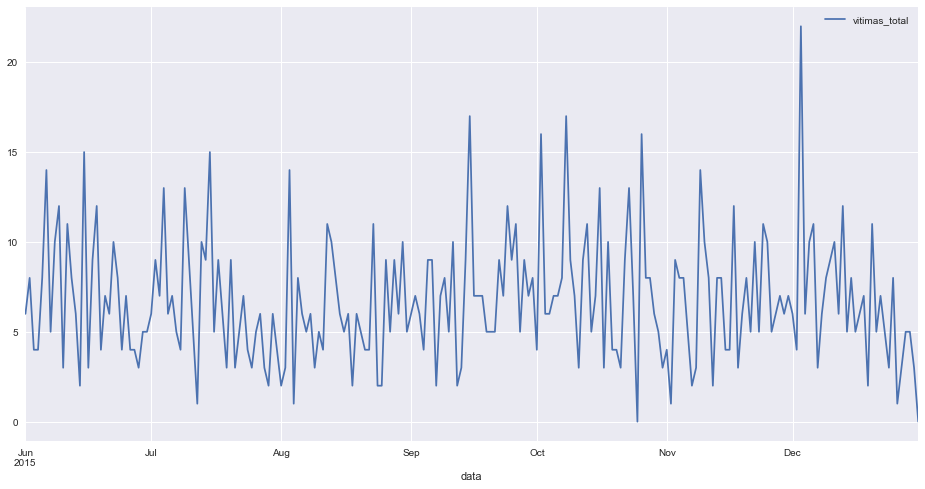

In [22]:
# Grafico
df_2015_vitimas.plot('data', 'vitimas_total')

##### Demais anos - 2016 a 2019

In [23]:
# Os passos a seguir serão bem semelhantes aos feitos para o ano de 2015

In [24]:
df_demais_anos.head()

,data,hora,natureza_acidente,situacao,bairro,endereco,numero,detalhe_endereco_acidente,complemento,endereco_cruzamento,...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 25
0,2019-01-01,00:41:00,SEM VÍTIMA,FINALIZADA,IPSEP,AV RECIFE,NaN,NaN,LADO OPOSTO AO Nº 3257,AV RECIFE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,01:37:00,SEM VÍTIMA,FINALIZADA,BOA VIAGEM,RUA PADRE BERNADINO PESSOA,NaN,RUA MINISTRO NELSON HUNGRIA,NaN,RUA PADRE BERNADINO PESSOA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,14:20:00,SEM VÍTIMA,CANCELADA,BOA VIAGEM,AV ENGENHEIRO DOMINGOS FERREIRA,NaN,RUA DOM JOSE LOPES,EM FRENTE A DELEGACIA DE BOA VIAGEM,LADO ESQUERDO DA PISTA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,02:53:00,SEM VÍTIMA,CANCELADA,IMBIRIBEIRA,AV GENERAL MAC ARTHUR,100,RUA JACY,EM FRENTE A ART LED ILUMINAÇÃO,AV GENERAL MAC ARTHUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,08:17:00,COM VÍTIMA,FINALIZADA,JAQUEIRA,RUA TITO ROSAS,63,NaN,ED. JARDINS DA JAQUEIRA,RUA TITO ROSAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_demais_anos.shape

(46494, 63)

In [26]:
df_demais_anos.columns

Index(['data', 'hora', 'natureza_acidente', 'situacao', 'bairro', 'endereco',
       'numero', 'detalhe_endereco_acidente', 'complemento',
       'endereco_cruzamento', 'numero_cruzamento', 'referencia_cruzamento',
       'bairro_cruzamento', 'num_semaforo', 'sentido_via', 'tipo', 'descricao',
       'auto', 'moto', 'ciclom', 'ciclista', 'pedestre', 'onibus', 'caminhao',
       'viatura', 'outros', 'vitimas', 'vitimasfatais', 'acidente_verificado',
       'tempo_clima', 'situacao_semaforo', 'sinalizacao', 'condicao_via',
       'conservacao_via', 'ponto_controle', 'situacao_placa',
       'velocidade_max_via', 'mao_direcao', 'divisao_via1', 'divisao_via2',
       'divisao_via3', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43',
       'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 26',
       'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30',
       'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34',
       'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38',

In [27]:
# Selecionando as colunas necessárias
df_demais_anos = df_demais_anos[['data', 'natureza_acidente', 'situacao', 'vitimas', 'vitimasfatais']]

In [28]:
df_demais_anos.dtypes

data                  object
natureza_acidente     object
situacao              object
vitimas              float64
vitimasfatais        float64
dtype: object

In [29]:
df_demais_anos = df_demais_anos.fillna(0)
df_demais_anos.head()

,data,natureza_acidente,situacao,vitimas,vitimasfatais
0,2019-01-01,SEM VÍTIMA,FINALIZADA,0.0,0.0
1,2019-01-01,SEM VÍTIMA,FINALIZADA,0.0,0.0
2,2019-01-01,SEM VÍTIMA,CANCELADA,0.0,0.0
3,2019-01-01,SEM VÍTIMA,CANCELADA,0.0,0.0
4,2019-01-01,COM VÍTIMA,FINALIZADA,1.0,0.0


In [30]:
# Mantendo a logica do ano de 2015, para o total de vitimas, foi utilizado (nesse caso) duas colunas vitimas e vitimasfatais
# para facilitar, criei uma coluna de vitimas totais (para depois agrupar por data e ter o total por dia)
df_demais_anos['vitimas_total'] = df_demais_anos['vitimas'] + df_demais_anos['vitimasfatais']

In [31]:
# Convertendo a coluna da data para formato data
df_demais_anos['data'] =  pd.to_datetime(df_demais_anos['data'], format='%Y-%m-%d')

In [32]:
# Agrupando as datas e somando o total de vítimas por dia
df_demais_anos_vitimas = df_demais_anos.groupby("data")['vitimas_total'].sum().reset_index()#.rename(columns={'vitimas':'vitimas_total'})
df_demais_anos_vitimas.head()

,data,vitimas_total
0,2016-01-01,4.0
1,2016-01-02,2.0
2,2016-01-03,6.0
3,2016-01-04,7.0
4,2016-01-05,2.0


<AxesSubplot:xlabel='data'>

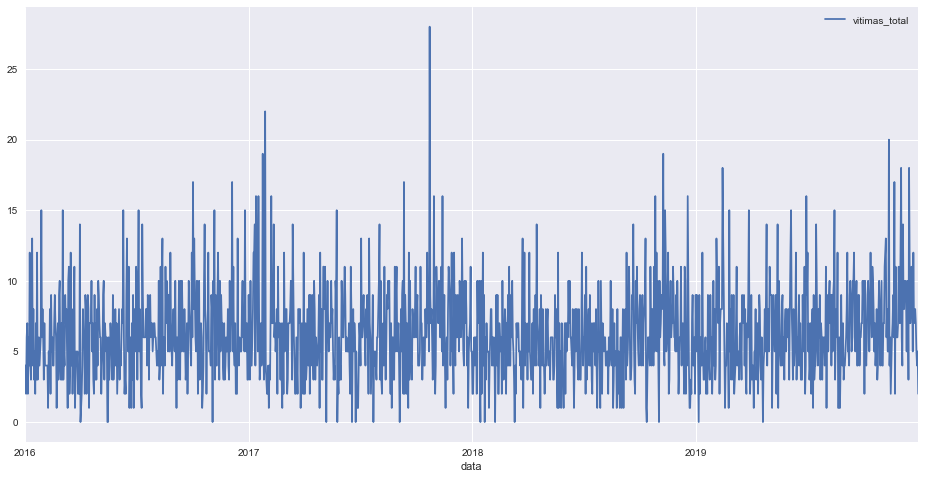

In [33]:
# Grafico
df_demais_anos_vitimas.plot('data', 'vitimas_total')

#### Unindo as bases com todos os anos

In [34]:
bases = [df_2015_vitimas,df_demais_anos_vitimas]
df = pd.concat(bases , axis=0, ignore_index=True)
df.head()

,data,vitimas_total
0,2015-06-01,6.0
1,2015-06-02,8.0
2,2015-06-03,4.0
3,2015-06-04,4.0
4,2015-06-05,8.0


In [35]:
min(df['data']), max(df['data'])

(Timestamp('2015-06-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

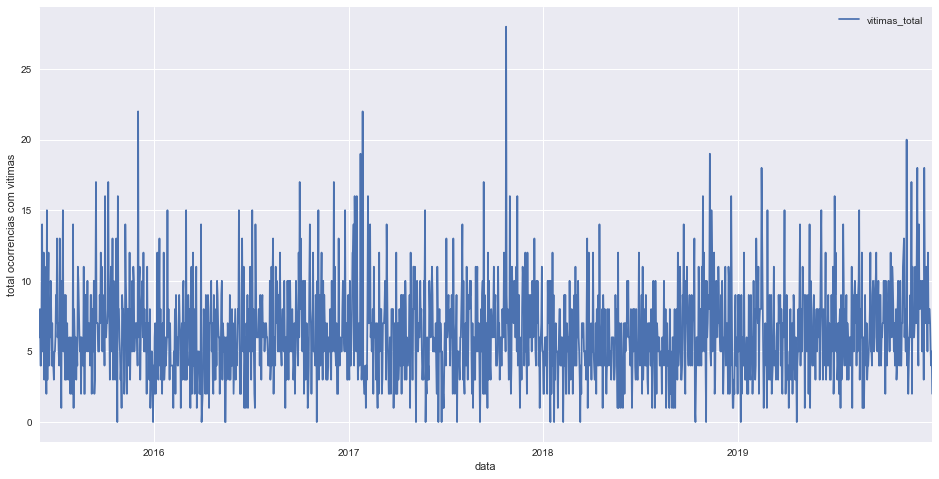

In [36]:
# Grafico
df.plot('data', 'vitimas_total')
plt.ylabel('total ocorrencias com vitimas')
plt.savefig(r'C:\Users\rapha\Documents\desafio_forecast\imagens\serie_todos_anos_ocorrencias.png')

## Análise descritiva da série temporal

* A partir daqui utilizou-se algumas etapas para verificar a estacionaridade da serie temporal e checar alguns comportamentos/descrever a serie e assim fazer sentido avançar pra próxima etapa de previsões de acidentes

##### A serie é estacionária? Para saber, aplicou-se o teste abaixo:

#### Teste Dickey-Fuller

* Hipótese nula (H0) : se não for rejeitada, sugere que a série temporal tem raiz unitária, ou seja, não é estacionária. Tem alguma estrutura dependente do tempo.

* Hipótese alternativa (H1) : A hipótese nula é rejeitada; sugere que a série temporal não tem uma raiz unitária, o que significa que é estacionária. Não tem estrutura dependente do tempo.

In [37]:
series = df.set_index('data')
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.576367
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [38]:
# Conclui-se pelo p-value < 0,05, aceita-se a hipótese H1, logo a serie é estacionária

#### Autocorrelação
* ACF (https://towardsdatascience.com/time-series-from-scratch-autocorrelation-and-partial-autocorrelation-explained-1dd641e3076f)

In [39]:
acf_values = acf(df['vitimas_total'])
np.around(acf_values,2)

array([ 1.  , -0.  ,  0.02,  0.05,  0.04,  0.02,  0.04,  0.06,  0.01,
        0.03,  0.02,  0.03, -0.01,  0.05,  0.09,  0.01,  0.01,  0.  ,
        0.02,  0.05,  0.02,  0.07, -0.  , -0.01,  0.04,  0.01, -0.01,
        0.04,  0.03,  0.04,  0.01, -0.02,  0.06])

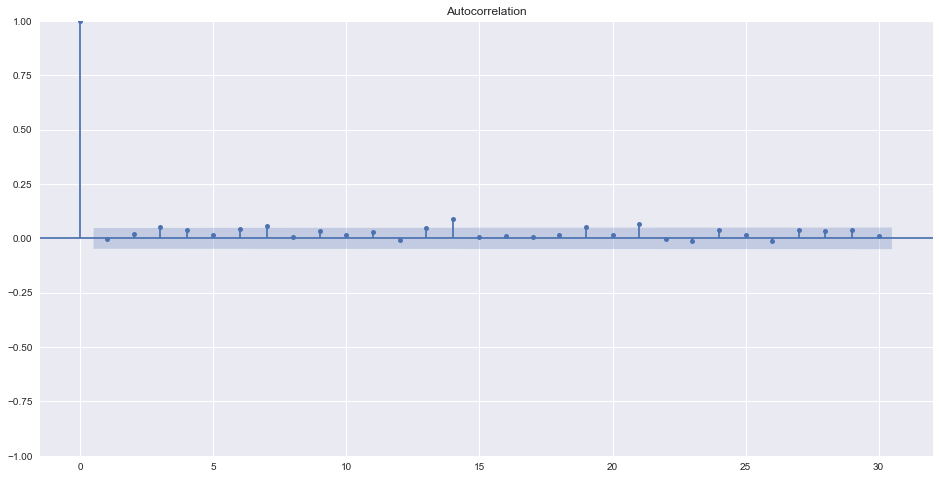

In [40]:
plot_acf(df['vitimas_total'], lags=30);

In [41]:
# Não existem lags relevantes, nota-se um comportamento suave, talvez o lag 14, apresente sutilmente um destaque frente aos demais
# o período 14 teve um impacto maior no valor de hoje

* PACF

In [42]:
pacf_values = pacf(df['vitimas_total'])
np.around(pacf_values,2)

array([ 1.  , -0.  ,  0.02,  0.05,  0.04,  0.01,  0.04,  0.06,  0.  ,
        0.03,  0.01,  0.02, -0.01,  0.04,  0.08,  0.  , -0.  , -0.01,
        0.01,  0.05,  0.01,  0.06, -0.01, -0.02,  0.03,  0.  , -0.02,
        0.02,  0.02,  0.04,  0.  , -0.03,  0.05])

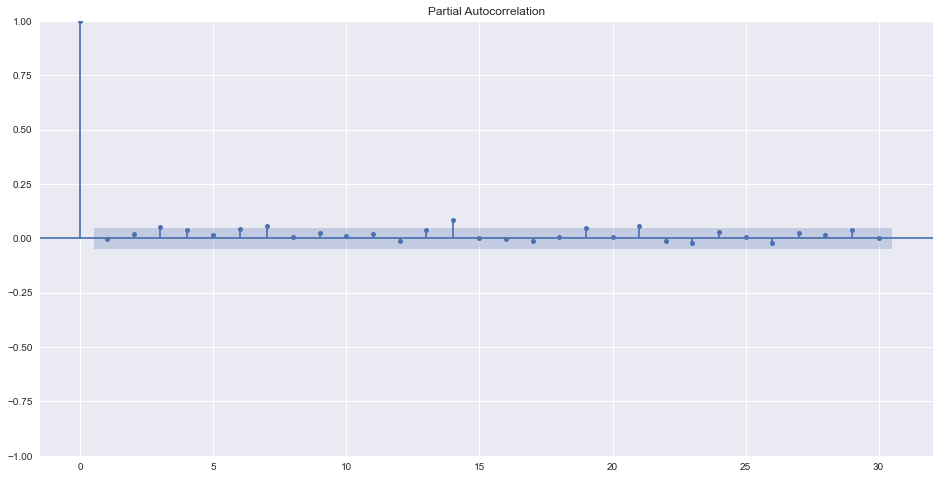

In [43]:
plot_pacf(df['vitimas_total'], lags=30);

* Estatisticas da serie

In [44]:
df['vitimas_total'].describe()

count    1675.000000
mean        6.324776
std         3.343651
min         0.000000
25%         4.000000
50%         6.000000
75%         8.000000
max        28.000000
Name: vitimas_total, dtype: float64

In [45]:
df.loc[df['vitimas_total'] == 28]

,data,vitimas_total
875,2017-10-23,28.0


In [46]:
# Em média ocorrem 6 acidentes por dia. Destaque para 28 acidentes notificados em um único dia.

* Decomposição da serie temporal

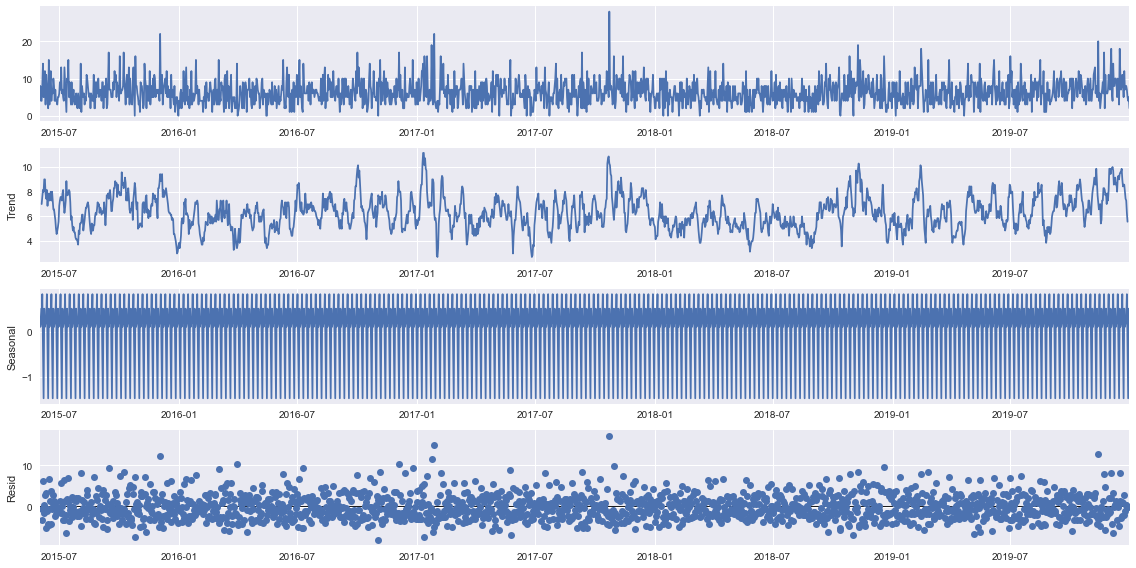

In [47]:
analysis = series[['vitimas_total']].copy()

decompose_result_mult = seasonal_decompose(analysis, model="additive")

tendencia = decompose_result_mult.trend
sazonalidade = decompose_result_mult.seasonal
residuos = decompose_result_mult.resid

decompose_result_mult.plot();
plt.savefig(r'C:\Users\rapha\Documents\desafio_forecast\imagens\decomposicao_serie.png')

In [48]:
# A tendencia e a sazonalidade parecem razoáveis e os resíduos aparentam estar normalmente distribuidos

##### Para avaliar se existe ou não tendência, utilizei do teste de Mann Kendall, que é descrito por:

#### Teste Man Kendall

* H0 (hipótese nula): Não há tendência presente nos dados

* H1 (hipótese alternativa): Uma tendência está presente nos dados. (Podendo ser uma tendência positiva ou negativa)

* fonte: https://www.statology.org/mann-kendall-test-python/

In [49]:
mk.original_test(df['vitimas_total'])

Mann_Kendall_Test(trend='no trend', h=False, p=0.2298866841985827, z=1.2006508060881858, Tau=0.019482515736728545, s=27314.0, var_s=517494068.0, slope=0.0, intercept=6.0)

In [50]:
# O p-value de 0,229 não é menor que 0,05, portanto, não há tendência

##### Para avaliar a existência de sazonalidade, calcula-se a média  para cada mês da série e avalia num gráfico

In [51]:
df_sazo = df.copy()
df_sazo['mes'] = df_sazo['data'].dt.month
df_sazo.head()

,data,vitimas_total,mes
0,2015-06-01,6.0,6
1,2015-06-02,8.0,6
2,2015-06-03,4.0,6
3,2015-06-04,4.0,6
4,2015-06-05,8.0,6


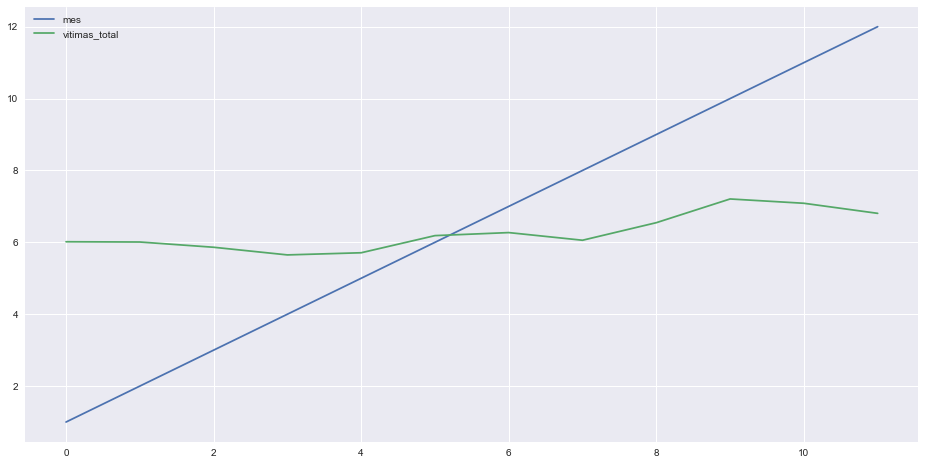

In [52]:
df_sazo = df_sazo.groupby('mes')['vitimas_total'].mean().reset_index().plot()
#df_sazo.plot('mes', 'vitimas_total')

In [53]:
# Pelo gráfico, e analisando a variável vitimas_fatais, nota-se que não existe sazonalidade na série

#### Salvando o arquivo da serie, afim de facilitar as análises no Notebook 2

In [54]:
df.to_csv(r'C:\Users\rapha\Documents\desafio_forecast\dataset\serie\serie_vitimas_desafio.csv', sep = ';', decimal = '.', index = False, encoding = 'ANSI')

In [55]:
# Referência
# https://operdata.com.br/blog/caracteristicas-das-series-temporais/#:~:text=S%C3%A9ries%20Temporais%3A%20Estacionariedade,redor%20de%20uma%20m%C3%A9dia%20constante.